# Pulse sequence evaluation

Using arbitrary units. Energy is normalized to the standard deviation in chemical shift strengths. Reduced Planck's constant $\hbar \equiv 1$.

In [39]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import multiprocessing as mp

In [2]:
sys.path.append('..')

In [3]:
import pulse_sequences as ps

## Define system

In [16]:
dipolar_strength = 1e1
pulse_width = 1e-4  # time is relative to chemical shift strength
delay = 1e-3
rot_error = 1e-2
N = 4  # number of spins
ensemble_size = 50

In [5]:
X, Y, Z = ps.get_collective_spin(N)

In [17]:
Hsys_ensemble = [ps.get_Hsys(N, dipolar_strength=dipolar_strength) for _ in range(ensemble_size)]
pulses_ensemble = [
    ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble
]

In [18]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Define and evaluate pulse sequences



In [245]:
f = ps.get_mean_fidelity(ps.yxx24, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999974016613897, 5.585304253189917)

In [246]:
f = ps.get_mean_fidelity(ps.yxx48, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999898398219236, 4.993098680149496)

In [24]:
f = ps.get_mean_fidelity(ps.mcts12_2, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

0.9940775812866163

In [25]:
ps.get_mean_fidelity(ps.mcts12_3, Utarget, pulses_ensemble)

0.9980730473527457

In [26]:
ps.get_mean_fidelity(ps.mcts12_4, Utarget, pulses_ensemble)

0.9980293112215896

In [27]:
ps.get_mean_fidelity(ps.az3, Utarget, pulses_ensemble)

0.9958282061761383

## Evaluate robustness

Looking at several different sources of errors:

- Non-negligible higher-order terms in Magnus expansion
- Rotation errors
- Phase transients
- Offset errors

In [91]:
pulses_ensemble = [
    ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=0)
    for H in Hsys_ensemble
]

In [97]:
yxx48_fidelities = np.array([
    ps.get_fidelity(ps.yxx48, Utarget, p)
    for p in pulses_ensemble
])

In [98]:
1-np.mean(yxx48_fidelities), np.std(yxx48_fidelities)

(1.0160178076867865e-05, 2.1976104601577872e-05)

In [102]:
yxx24_fidelities = np.array([
    ps.get_fidelity(ps.yxx24, Utarget, p)
    for p in pulses_ensemble
])

In [103]:
1-np.mean(yxx24_fidelities), np.std(yxx24_fidelities)

(2.598338609938189e-06, 5.592592951128164e-06)

In [105]:
az3_fidelities = np.array([
    ps.get_fidelity(ps.az3, Utarget, p)
    for p in pulses_ensemble
])

In [106]:
1-np.mean(az3_fidelities), np.std(az3_fidelities)

(0.0029093752036906118, 0.004033137682925701)

### Rotation errors

In [288]:
rot_errors = np.linspace(-.1, .1, 25)

In [295]:
def f(pulse_sequence, rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(pulse_sequence, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [296]:
def get_rot_data(pulse_sequence, rot_errors, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.map(f, [(pulse_sequence, r) for r in rot_errors])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [87]:
with mp.Pool(4) as p:
    yxx48_f_rot = p.map(f, rot_errors)

In [88]:
yxx48_f_rot, yxx48_f_rot_std = zip(*yxx48_f_rot)

In [89]:
yxx48_f_rot = np.array(yxx48_f_rot)
yxx48_f_rot_std = np.array(yxx48_f_rot_std)

In [73]:
def g(rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.yxx24, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [114]:
with mp.Pool(4) as p:
    yxx24_f_rot = p.map(g, rot_errors)

In [115]:
yxx24_f_rot, yxx24_f_rot_std = zip(*yxx24_f_rot)

In [116]:
yxx24_f_rot = np.array(yxx24_f_rot)
yxx24_f_rot_std = np.array(yxx24_f_rot_std)

In [108]:
def h(rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.az3, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [109]:
with mp.Pool(4) as p:
    az3_f_rot = p.map(h, rot_errors)

In [112]:
az3_f_rot, az3_f_rot_std = zip(*az3_f_rot)

In [113]:
az3_f_rot = np.array(az3_f_rot)
az3_f_rot_std = np.array(az3_f_rot_std)

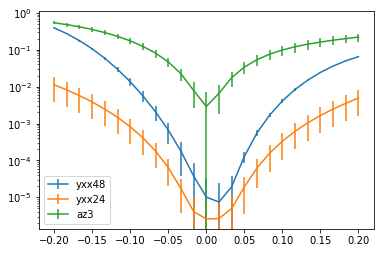

In [117]:
plt.errorbar(rot_errors, 1-yxx48_f_rot, yerr=yxx48_f_rot_std, label='yxx48')
plt.errorbar(rot_errors, 1-yxx24_f_rot, yerr=yxx24_f_rot_std, label='yxx24')
plt.errorbar(rot_errors, 1-az3_f_rot, yerr=az3_f_rot_std, label='az3')
plt.yscale('log')
plt.legend()

In [278]:
def h(rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(seqs[69], Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [279]:
with mp.Pool(4) as p:
    az12_1_f_rot = p.map(h, rot_errors)

In [280]:
az12_1_f_rot, az12_1_f_rot_std = zip(*az12_1_f_rot)

In [281]:
az12_1_f_rot = np.array(az12_1_f_rot)
az12_1_f_rot_std = np.array(az12_1_f_rot_std)

## TODO

Figure out how to map pulse sequence and rot error to `f`, so that I can reuse a lot of the code from above (and more easily try out new sequences)

In [297]:
az12_1_f_rot, az12_1_f_rot_std = get_rot_data(seqs[69], rot_errors)

TypeError: f() missing 1 required positional argument: 'rot_error'

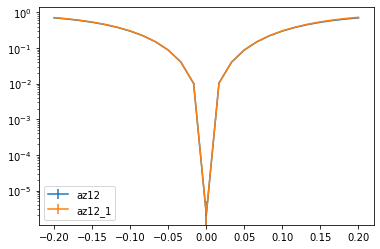

In [284]:
plt.errorbar(rot_errors, 1-az12_f_rot, yerr=az12_f_rot_std, label='az12')
plt.errorbar(rot_errors, 1-az12_1_f_rot, yerr=az12_1_f_rot_std, label='az12_1')
plt.yscale('log')
plt.legend()

### Phase transients

In [125]:
phase_transients = np.linspace(0, .05, 25)

In [119]:
def f(pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.yxx48, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [146]:
with mp.Pool(4) as p:
    yxx48_fidelities_pt = p.map(f, phase_transients)

In [147]:
yxx48_f_pt, yxx48_f_pt_std = zip(*yxx48_fidelities_pt)

In [148]:
yxx48_f_pt = np.array(yxx48_f_pt)
yxx48_f_pt_std = np.array(yxx48_f_pt_std)

In [131]:
def g(pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.yxx24, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [149]:
with mp.Pool(4) as p:
    yxx24_fidelities_pt = p.map(g, phase_transients)

In [150]:
yxx24_f_pt, yxx24_f_pt_std = zip(*yxx24_fidelities_pt)

In [151]:
yxx24_f_pt = np.array(yxx24_f_pt)
yxx24_f_pt_std = np.array(yxx24_f_pt_std)

In [155]:
def h(pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(ps.az3, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [156]:
with mp.Pool(4) as p:
    az3_fidelities_pt = p.map(h, phase_transients)

In [157]:
az3_f_pt, az3_f_pt_std = zip(*az3_fidelities_pt)

In [158]:
az3_f_pt = np.array(az3_f_pt)
az3_f_pt_std = np.array(az3_f_pt_std)

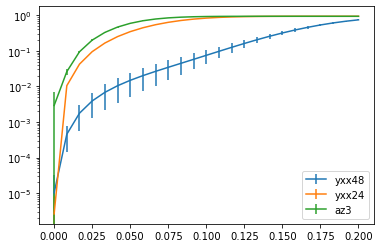

In [161]:
plt.errorbar(phase_transients, 1-yxx48_f_pt, yerr=yxx48_f_pt_std, label='yxx48')
plt.errorbar(phase_transients, 1-yxx24_f_pt, yerr=yxx24_f_pt_std, label='yxx24')
plt.errorbar(phase_transients, 1-az3_f_pt, yerr=az3_f_pt_std, label='az3')
plt.yscale('log')
plt.legend()

## Check candidates from CSV file

In [254]:
df = pd.read_csv('../../data/2021-02/20210219-082529/candidates_sorted.csv')

In [255]:
df['sequence'] = df['sequence'].apply(lambda x: [int(i) for i in x[1:-1].split(',')])

In [256]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])

In [257]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: np.argwhere(x)[0][0])

In [258]:
df['full_sequence'] = df['sequence'] + df['last_pulse'].apply(lambda x: [x])

In [259]:
unique_sequences = df['full_sequence'].map(lambda x: ','.join([str(i) for i in x])).unique()

In [260]:
unique_sequences = [[int(j) for j in i.split(',')] for i in unique_sequences]

In [222]:
np.zeros(5)

array([0., 0., 0., 0., 0.])

In [264]:
N_seq = 250
seqs = []
fidelities = np.zeros(N_seq)
for i in range(N_seq):
    if i % 10 == 0:
        print(i)
    candidate = unique_sequences[i]
    seqs.append(candidate)
    f = ps.get_mean_fidelity(candidate, Utarget, pulses_ensemble)
    fidelities[i] = f
    # print(i, f)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


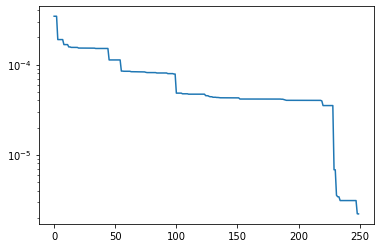

In [276]:
plt.plot(1 - fidelities)
plt.yscale('log')

In [272]:
fidelities.sort()

In [267]:
np.argmin(1 - fidelities), (1 - fidelities).min(), -np.log10((1 - fidelities).min())

(69, 2.198749538995237e-06, 5.657824238591604)

In [277]:
seqs[69]

[3, 1, 4, 4, 2, 4, 1, 4, 4, 2, 3, 3]

In [269]:
df['full_sequence']

0         [4, 0, 4, 2, 0, 2, 4, 0, 4, 2, 0, 2]
1         [4, 0, 4, 2, 0, 2, 4, 0, 4, 2, 0, 2]
2         [4, 0, 4, 1, 0, 1, 4, 0, 4, 1, 0, 1]
3         [4, 0, 4, 2, 0, 2, 4, 0, 4, 2, 0, 2]
4         [4, 0, 4, 2, 0, 2, 4, 0, 4, 2, 0, 2]
                          ...                 
340388    [4, 0, 4, 4, 1, 0, 3, 3, 3, 2, 4, 1]
340389    [2, 2, 2, 3, 2, 3, 1, 3, 3, 1, 2, 3]
340390    [4, 2, 4, 1, 4, 4, 0, 4, 2, 2, 2, 0]
340391    [4, 2, 2, 0, 2, 3, 3, 3, 0, 2, 3, 2]
340392    [2, 2, 4, 2, 3, 2, 0, 3, 3, 3, 2, 0]
Name: full_sequence, Length: 340393, dtype: object

In [270]:
print(df['full_sequence'][23])

[4, 0, 4, 2, 0, 2, 4, 0, 4, 2, 0, 2]


In [264]:
names = [
    r'\tau_{\pi/2}, \tau',
    r'X, \tau',
    r'-X, \tau',
    r'Y, \tau',
    r'-Y, \tau',
]

In [268]:
sequence_string = [names[i] for i in df['full_sequence'][23]]

print('$', ', '.join(sequence_string[:12]), '$')
print('$', ', '.join(sequence_string[12:24]), '$')
print('$', ', '.join(sequence_string[24:36]), '$')
print('$', ', '.join(sequence_string[36:48]), '$')

$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, -X, \tau, -Y, \tau, -X, \tau, -Y, \tau, X, \tau $
$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -X, \tau, -X, \tau, -X, \tau $
$ Y, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -Y, \tau, Y, \tau, X, \tau $
$ Y, \tau, -Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, Y, \tau, -X, \tau $


Pulse sequence 23:

$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, -X, \tau, -Y, \tau, -X, \tau, -Y, \tau, X, \tau $
$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -X, \tau, -X, \tau, -X, \tau $
$ Y, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -Y, \tau, Y, \tau, X, \tau $
$ Y, \tau, -Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, Y, \tau, -X, \tau $

In [223]:
fidelities = np.array(
    [ps.get_fidelity(df['full_sequence'][23], Utarget, pulses)
     for pulses in pulses_ensemble]
)

In [224]:
np.mean(fidelities)

0.9901248881032397

In [225]:
np.std(fidelities)

0.013279629621136551

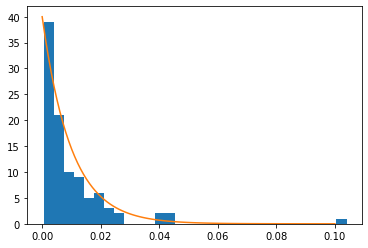

In [231]:
plt.hist(1 - fidelities, bins=30)
# fit exponential curve
X = np.linspace(0, .1, 100)
Y = np.exp(-1 / np.mean(1 - fidelities) * X)
plt.plot(X, Y * 40)